In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from astropy.io import fits
from scipy import interpolate

import h5py


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


## Exploring H3 spectra.

> Curating spectra (in .h5 format)

In [ ]:
# restore spectra catalog
fcat = h5py.File('../H3_spectra.h5', 'r')

# find all paths
obj_paths = []
for key1 in list(fcat.keys())[0:-1]:
    for key2 in list(fcat[key1].keys()):
        for key3 in list(fcat[key1+"/"+key2].keys()):
            objs = list(fcat[key1+"/"+key2+"/"+key3+"/v3.0"].keys())
            obj_paths.append([key1+"/"+key2+"/"+key3+"/v3.0/"+obj for obj in objs])

obj_paths = np.array([item for sublist in obj_paths for item in sublist])
obj_ids = np.array([x.split("/")[-1] for x in obj_paths])

#----------------------------------------------------------------------------------------------
# read H3 catalog
hdulist = fits.open('../H3_labels.fits')
H3_id = hdulist[1].data['H3_ID'].astype("str")
SNR = hdulist[1].data['SNR']
teff = hdulist[1].data['Teff']
logg = hdulist[1].data['logg']
feh = hdulist[1].data['FeH']

#----------------------------------------------------------------------------------------------
# initiate list
rest_wave = []
flux_spectra = []
eflux_spectra = []
err_array = [] 
H3_id_2 = []
ind_choose = []

#-----------------------------------------------------------------------------------------
# cross matching
# the SNR in rcat is using only 5160A-5290A
indx =0
for i in range(H3_id.size):
    ind = np.where(obj_ids == H3_id[i])[0]
    if len(ind) > 0:
        rest_wave.append(np.array(fcat[obj_paths[ind[0]]]['mod_wave_rest']))
        err_array.append(np.nanmedian(np.array(fcat[obj_paths[ind[0]]]['obs_flux'])\
                                 /np.array(fcat[obj_paths[ind[0]]]['obs_eflux'])))
        eflux_spectra.append(np.array(fcat[obj_paths[ind[0]]]['obs_eflux']))
        flux_spectra.append(np.array(fcat[obj_paths[ind[0]]]['obs_flux']))
        H3_id_2.append(H3_id[i])
        ind_choose.append(i)
        
#-----------------------------------------------------------------------------------------
# convert to numpy array
rest_wave = np.array(rest_wave)
err_array = np.array(err_array)
flux_spectra = np.array(flux_spectra)
eflux_spectra = np.array(eflux_spectra)
H3_id_2 = np.array(H3_id_2)
ind_choose = np.array(ind_choose)


In [ ]:
np.savez("../H3_spectra.npz",\
         rest_wave = rest_wave,\
         err_array = err_array,\
         flux_spectra = flux_spectra,\
         eflux_spectra = eflux_spectra,\
         H3_id = H3_id[ind_choose],
         SNR = SNR[ind_choose],\
         teff = teff[ind_choose],\
         logg = logg[ind_choose],\
         feh = feh[ind_choose],\
         h3_flag = h3_flag[ind_choose])


In [ ]:
plt.scatter(SNR[ind_choose],err_array, s=1)
plt.xlabel("rcat SNR")
plt.ylabel("Median (eflux / flux)")

In [ ]:
plt.hist(SNR[ind_choose]-err_array, bins=100);
plt.xlabel("rcat SNR - fcat SNR")

outlier_1 = np.where(SNR[ind_choose]-err_array > 20.)[0]
print(H3_id_2[outlier_1][0])
#outlier_2 = np.where(err_array-SNR[ind_choose] > 25.)[0]
#print(H3_id_2[outlier_2][0])

print(np.sum(np.abs(SNR[ind_choose]-err_array)/np.abs(SNR[ind_choose]+err_array)/2. > 0.05)/SNR[ind_choose].size)

> H3 spectra S/N.

In [ ]:
# restore labels
hdulist = fits.open('../H3_labels.fits')
H3_id = hdulist[1].data['H3_ID']
SNR = hdulist[1].data['SNR']

print(SNR.shape)
print(np.sum(SNR > 10.))
plt.hist(SNR, bins=100, cumulative=True);

> Explore H3 labels.

In [ ]:
# restore labels
hdulist = fits.open('../H3_labels.fits')
H3_id = hdulist[1].data['H3_ID']
SNR = hdulist[1].data['SNR']
teff = hdulist[1].data['Teff']
logg = hdulist[1].data['logg']
feh = hdulist[1].data['FeH']


#=====================================================================================
# import packages
import read_mist_models

#-----------------------------------------------------------------------------------------
# initiate the plot
fig = plt.figure(figsize=[10,9]);
ax = fig.gca();

# axis labels
ax.set_xlabel("Teff [K]", fontsize=30, labelpad=10);
ax.set_ylabel("Log g", fontsize=30, labelpad=10);

# set range
plt.xlim([3500,7000])
plt.ylim([-0.5,5.])

# invert axis
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# add padding
ax.tick_params(axis='x', pad=10);

# reduce number of ticks
plt.locator_params(nbins=5)


#=====================================================================================
# plot results
sc = plt.scatter(teff, logg, s=3, edgecolor="none", cmap=plt.cm.get_cmap('jet'),\
                 c=feh, vmin=-2.00, vmax=0., rasterized=True)

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_m2.00_afe_p0.0_vvcrit0.4_full.iso')

# extract information
age_ind = iso.age_index(np.log10(7*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, ls="--", label="[Fe/H] = -0.50")

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_m1.00_afe_p0.0_vvcrit0.4_full.iso')
     
# extract information
age_ind = iso.age_index(np.log10(7*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, label="[Fe/H] = 0.00")

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_full.iso')

# extract information
age_ind = iso.age_index(np.log10(10*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, ls=":", label="[Fe/H] = 0.50")


#=====================================================================================
# save figure
plt.tight_layout()
plt.savefig("../Fig7.pdf")


> Explore H3 synthetic grid.

In [ ]:
# import packages
import os
import numpy as np
import h5py
from phil_h3_smoothing import smoothspec

#---------------------------------------------------------------------------------
# all the hdf5 files
file_list = os.listdir("../H3_grid")

# loop over all files
spectra = []
parameters = []
wavelength = []
for file_name in file_list:
    fcat = h5py.File('../H3_grid/' + file_name, 'r')
    spectra.extend(np.array(fcat['spectra'])/np.array(fcat['continuua']))
    wavelength = np.array(fcat['wavelengths'])
    parameters_temp = np.array(fcat['parameters'])
    parameters.extend(np.array([np.array(list(parameters_temp[i])) \
                                for i in range(len(parameters_temp))]))
spectra = np.array(spectra)
parameters = np.array(parameters)
wavelength = np.array(wavelength)
print(spectra.shape)
print(parameters.shape)
print(wavelength.shape)
    
#---------------------------------------------------------------------------------
# convert log Teff to Teff
parameters[:,0] = 10.**parameters[:,0] 

# restrict to Teff = 3500-10000, logg = 0-5
ind = (parameters[:,0] >= 3500.)*(parameters[:,0] <= 10000.)\
       *(parameters[:,1] >= 0.)*(parameters[:,1] <= 5.)
parameters = parameters[ind,:]
spectra = spectra[ind,:]


In [ ]:
print(wavelength)

In [ ]:
# define wavelength range
waverange = [5100, 5350]

# define output wavleength
wavelength_i = np.copy(wavelength)
wavelength_o = []
resolution_o = 100000
resolution = resolution_o/2.355

i = 1
while True:
    wave_i = waverange[0]*(1.0 + 1.0/(3.0*resolution))**(i-1.0)
    if wave_i <= waverange[1]:
        wavelength_o.append(wave_i)
        i += 1
    else:
        break
wavelength_o = np.array(wavelength_o)
        
# smooth the spectra
spectra_o = []
for i in range(spectra.shape[0]):
    spectra_o.append(smoothspec(wavelength_i,spectra[i,:], resolution_o,\
                                outwave=wavelength_o, smoothtype='R', fftsmooth=True, inres=500000.0))
spectra = np.copy(spectra_o)

np.savez("../H3_training_grid.npz",\
         labels = parameters,\
         spectra = spectra,\
         wavelength = wavelength_o)


In [ ]:
print(wavelength_o)
print(wavelength_o.shape)
print(spectra.shape)

In [ ]:
plt.plot(spectra[2,:])

## Spectral emulation with IMLE / autoregressive flow.

> Plot the training losses.

In [ ]:
mse_err_array = []
for i in range(30):
    temp = np.load("../mse_err_deconv_256x2_" + str((i+1)*100-1) +  ".npz")
    mse_err_array.append(temp["mse_err"])
mse_err_array = np.array(mse_err_array)

fig = plt.figure(figsize=[10.,8.])
ax = fig.gca();
ax.set_yscale('log')
plt.plot(mse_err_array)

In [ ]:
# The Payne training loss
temp = np.load("../training_loss_payne.npz")
training_loss = temp["training_loss"]
validation_loss = temp["validation_loss"]
plt.plot(training_loss)
plt.plot(validation_loss)
plt.ylim({10,100})
plt.yscale('log')

temp = np.load("../training_loss_resnet.npz")
training_loss = temp["training_loss"]
validation_loss = temp["validation_loss"]
plt.plot(training_loss)
plt.plot(validation_loss)

> Prediction uncertainty (Kurucz)

In [ ]:
# restore wavelength
temp = np.load("../apogee_windows.npz")
wavelength_template = temp["filter_wavelength"]
# wavelength_template = temp["filter_wavelength"][:7163]

# restore results
# temp = np.load("../results_spectra_deconv_256x2_2999.npz")
# Y_u_all = temp["data_np"].T
# predict_flux_array = temp["samples_np"].T

# predict_flux_array = np.load("../predict_flux_array.npy").T
# print(predict_flux_array.shape)

# temp = np.load("../ind_shuffle_kurucz.npz")
# ind_shuffle = temp["ind_shuffle"]
# print(ind_shuffle.shape)

#-------------------------------------------------------------------------------------------------
# restore training set
# temp = np.load("../mock_all_spectra_no_noise_resample_prior_large.npz")
# labels_array = temp["labels"][:,:Y_u_all.shape[1]]

# labels_array = temp["labels"][:,ind_shuffle][:,12000:14100]
# Y_u_all = temp["spectra"].T[:7163,:][:,ind_shuffle][:,12000:14100]
# print(Y_u_all.shape)

# calculate flux deviation
flux_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=1)
max_deviate = np.percentile(np.abs(Y_u_all - predict_flux_array),95,axis=1)
median_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=0)


#===============================================================================================
# initiate the plot
fig = plt.figure(figsize=[22,15]);

# combine labels
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=0, bottom=0, left=0, right=0)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,0))

# axis labels
ax.set_xlabel(r"Wavelength [A]");
ax.set_ylabel(r"Normalized flux + shift");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([15200,15300])
plt.ylim([0.3,1.1])

#-------------------------------------------------------------------------------------------------
# plot results
ind_plot = 54
ind_standard = 4

plt.plot(wavelength_template, Y_u_all[:,ind_standard],\
         color=cb2[3], lw=2, label="Ab initio model spectrum")
plt.plot(wavelength_template, predict_flux_array[:,ind_standard],\
         color="black", ls="--", lw=2, label="The Payne approximation")

plt.plot(wavelength_template, Y_u_all[:,ind_plot] - 0.3,\
         color=cb2[3], lw=2)
plt.plot(wavelength_template, predict_flux_array[:,ind_plot] - 0.3,\
         color="black", ls="--", lw=2)

# add legend
plt.legend(loc="lower right", fontsize=25, frameon=False,\
            borderpad=0.1, labelspacing=0.5)
    

#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,0))

# axis labels
ax.set_xlabel(r"Wavelength [A]");
ax.set_ylabel(r"Median approximation error");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([15200,15300])
plt.ylim([10**-4,10**-2])

# plot in log scale
ax.set_yscale('log');

#-------------------------------------------------------------------------------------------------
# plot results
flux_deviate_part = np.median(np.abs(Y_u_all-predict_flux_array),axis=1)
plt.plot(wavelength_template, flux_deviate_part, color="black", lw=2)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,1))

# axis labels
ax.set_xlabel(r"(Wavelength) Median approximation error of The Payne");
ax.set_ylabel(r"# Cross validation models");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([-4,-1.])
plt.ylim([0,220])
#plt.ylim([0,1200])

# set the range
plt.xticks([-4,-3,-2,-1],\
           ["$\mathregular{10^{-4}}$", "$\mathregular{10^{-3}}$",\
            "$\mathregular{10^{-2}}$", "$\mathregular{10^{-1}}$"])

#-------------------------------------------------------------------------------------------------
# plot result
choose = (labels_array[0,:] > 3500.)*(labels_array[0,:] < 4500.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color=cb2[0], lw=3)

choose = (labels_array[0,:] > 4500.)*(labels_array[0,:] < 6000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color=cb2[3], lw=3)

choose = (labels_array[0,:] > 6000.)*(labels_array[0,:] < 8000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color="black", lw=3)

# add legend
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[0], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3000K - 4500K}$")
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[3], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4500K - 6000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
          label=r"$\mathregular{T_{\rm eff} = 6000K - 8000K}$")

plt.legend(loc="upper right", fontsize=25, frameon=False,\
            borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,1))

# axis labels
ax.set_xlabel(r"(Spectrum) Median approximation error of The Payne");
ax.set_ylabel(r"Cumulative # wavelength pixels [%]");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([10**-4,10**-0.9])
plt.ylim([0.,1.0])

ax.set_xscale('log');

#-------------------------------------------------------------------------------------------------
# add end points
flux_deviate = np.concatenate([flux_deviate,[1.]])
max_deviate = np.concatenate([max_deviate,[1.]])

# plot result
plt.hist(flux_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black")
plt.hist(max_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black", ls=":")

# add legend
l3, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls="-", label="Median")
l4, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls=":", label=r"$\mathregular{2\sigma}$")

plt.legend(loc="upper left",\
           fontsize=25, frameon=False, borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# save figure
plt.tight_layout()
plt.savefig("../Fig4.pdf")


> Make Payne predictions.

In [3]:
# import The Payne github
from The_Payne import spectral_model

# restore array
tmp = np.load("../NN_normalized_spectra.npz")
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]

tmp.close()
NN_coeffs = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

#------------------------------------------------------------------------------------------------
# read spectra
temp = np.load("../H3_training_grid.npz")
labels = temp["labels"]
labels[:,0] = labels[:,0]/1000.
Y_u_all = temp["spectra"].T

# calculate spectrum
predict_flux_array = []

for i in range(labels.shape[0]):
    label_test = (labels[i,:]-x_min)/(x_max-x_min) - 0.5
    predict_flux_array.append(spectral_model.get_spectrum_from_neural_net(scaled_labels = label_test,\
                                                       NN_coeffs = NN_coeffs))

predict_flux_array = np.array(predict_flux_array).T
print(predict_flux_array.shape)

(6097, 19652)


> Prediction uncertainty (for H3).

(4, 1652)
(1652,)


/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:211: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/yting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:216: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplo

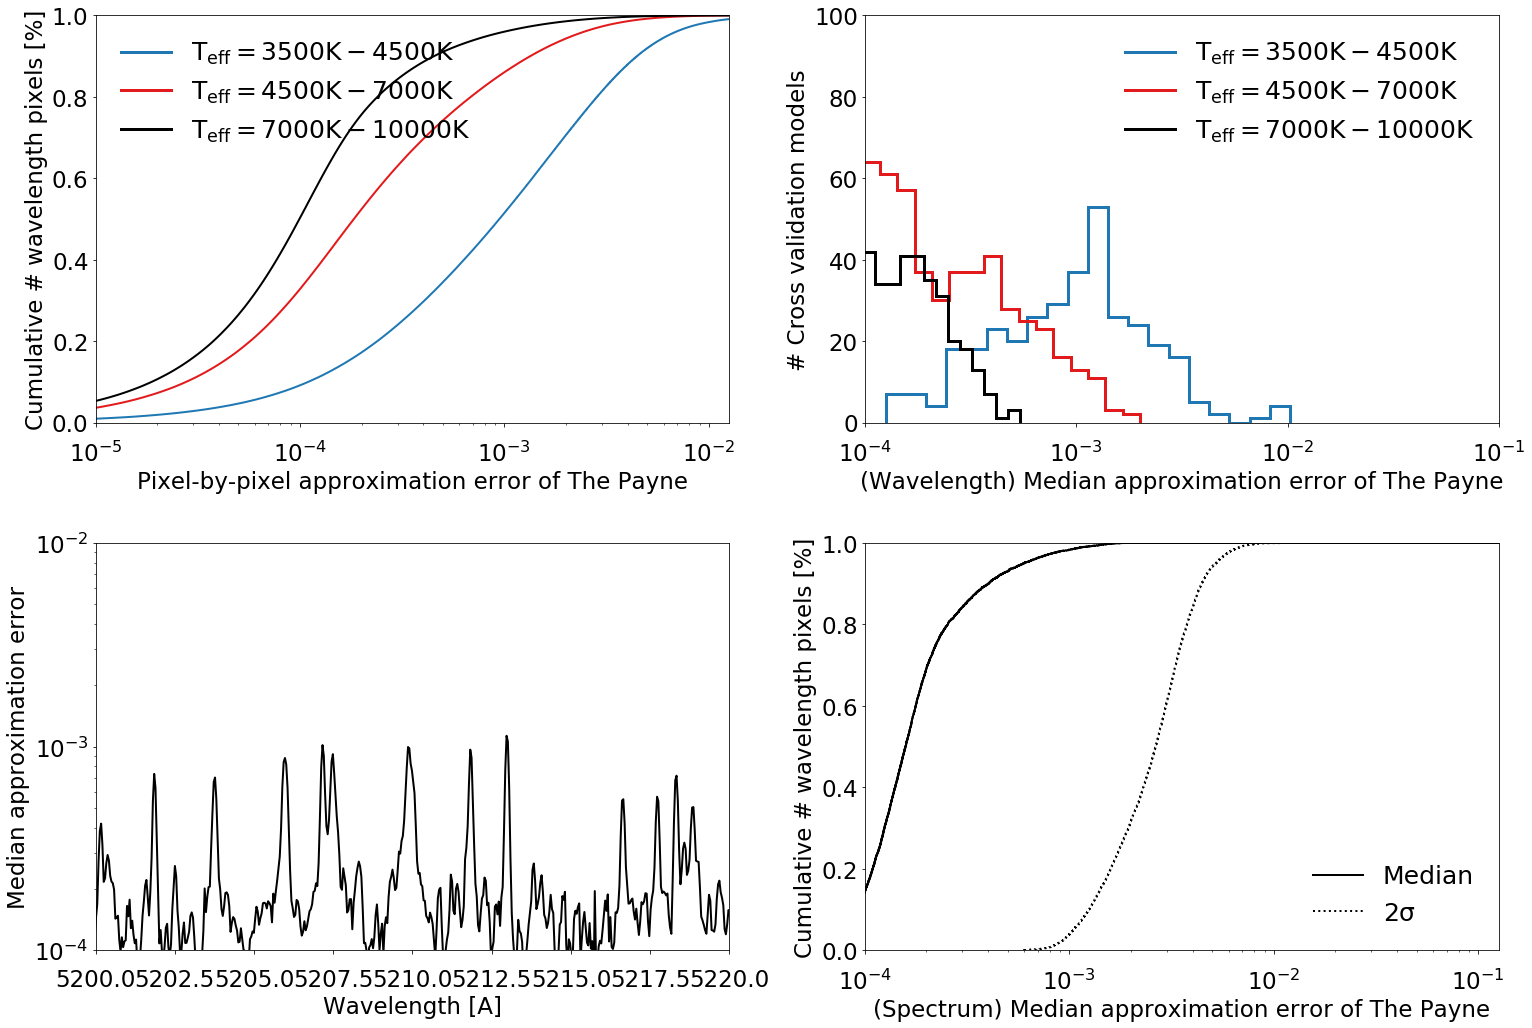

In [6]:
# restore results
#predict_flux_array = np.load("../predict_flux_array.npy").T

# load training set
temp = np.load("../H3_training_grid.npz")
labels_array = temp["labels"].T
Y_u_all = temp["spectra"].T
wavelength_template = temp["wavelength"]

#-------------------------------------------------------------------------------------------------
# restrict to only the validation set
temp = np.load("../ind_shuffle_payne_h3.npz")
ind_shuffle = temp["ind_shuffle"]
Y_u_all = Y_u_all[:,ind_shuffle][:,18000:]
predict_flux_array = predict_flux_array[:,ind_shuffle][:,18000:]
labels_array = labels_array[:,ind_shuffle][:,18000:]

#-------------------------------------------------------------------------------------------------
# calculate flux deviation
flux_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=1)
max_deviate = np.percentile(np.abs(Y_u_all - predict_flux_array),95,axis=1)
median_deviate = np.median(np.abs(Y_u_all - predict_flux_array),axis=0)


#===============================================================================================
# initiate the plot
fig = plt.figure(figsize=[22,15]);

# combine labels
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=0, bottom=0, left=0, right=0)


#===============================================================================================
# plot results
# ax = plt.subplot2grid((2,2), (0,0))

# # axis labels
# ax.set_xlabel(r"Wavelength [A]");
# ax.set_ylabel(r"Normalized flux + shift");

# ax.tick_params(axis='x', pad=15);

# # set the range
# plt.xlim([5200,5220])
# plt.ylim([0.1,1.1])

# #-------------------------------------------------------------------------------------------------
# # plot results
# ind_plot = 54
# ind_standard = 5

# plt.plot(wavelength_template, Y_u_all[:,ind_standard],\
#          color=cb2[3], lw=2, label="Ab initio model spectrum")
# plt.plot(wavelength_template, predict_flux_array[:,ind_standard],\
#          color="black", ls="--", lw=2, label="The Payne approximation")

# plt.plot(wavelength_template, Y_u_all[:,ind_plot] - 0.3,\
#          color=cb2[3], lw=2)
# plt.plot(wavelength_template, predict_flux_array[:,ind_plot] - 0.3,\
#          color="black", ls="--", lw=2)

# # add legend
# plt.legend(loc="lower right", fontsize=25, frameon=False,\
#             borderpad=0.1, labelspacing=0.5)
    

#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,0))

# axis labels
ax.set_xlabel(r"Wavelength [A]");
ax.set_ylabel(r"Median approximation error");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([5200,5220])
plt.ylim([10**-4,10**-2])

# plot in log scale
ax.set_yscale('log');

#-------------------------------------------------------------------------------------------------
# plot results
flux_deviate_part = np.median(np.abs(Y_u_all-predict_flux_array),axis=1)
plt.plot(wavelength_template, flux_deviate_part, color="black", lw=2)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,1))

# axis labels
ax.set_xlabel(r"(Wavelength) Median approximation error of The Payne");
ax.set_ylabel(r"# Cross validation models");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([-4,-1.])
#plt.ylim([0,1000])
plt.ylim([0,100])

# set the range
plt.xticks([-4,-3,-2,-1],\
           ["$\mathregular{10^{-4}}$", "$\mathregular{10^{-3}}$",\
            "$\mathregular{10^{-2}}$", "$\mathregular{10^{-1}}$"])

#-------------------------------------------------------------------------------------------------
# plot result
print(labels_array.shape)
choose = (labels_array[0,:] > 3500.)*(labels_array[0,:] < 4500.)
print(choose.shape)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color=cb2[0], lw=3)

choose = (labels_array[0,:] > 4500.)*(labels_array[0,:] < 7000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color=cb2[3], lw=3)

choose = (labels_array[0,:] > 7000.)*(labels_array[0,:] < 10000.)
plt.hist(np.log10(median_deviate)[choose],\
         histtype="step", bins=20, color="black", lw=3)

# add legend
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[0], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3500K - 4500K}$")
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[3], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4500K - 7000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
          label=r"$\mathregular{T_{\rm eff} = 7000K - 10000K}$")

plt.legend(loc="upper right", fontsize=25, frameon=False,\
            borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (1,1))

# axis labels
ax.set_xlabel(r"(Spectrum) Median approximation error of The Payne");
ax.set_ylabel(r"Cumulative # wavelength pixels [%]");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([10**-4,10**-0.9])
plt.ylim([0.,1.0])

ax.set_xscale('log');

#-------------------------------------------------------------------------------------------------
# add end points
flux_deviate = np.concatenate([flux_deviate,[1.]])
max_deviate = np.concatenate([max_deviate,[1.]])

# plot result
plt.hist(flux_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black")
plt.hist(max_deviate,\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black", ls=":")

# add legend
l3, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls="-", label="Median")
l4, = plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=2, ls=":", label=r"$\mathregular{2\sigma}$")

plt.legend(loc="lower right",\
           fontsize=25, frameon=False, borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# plot results
ax = plt.subplot2grid((2,2), (0,0))

# axis labels
ax.set_xlabel(r"Pixel-by-pixel approximation error of The Payne");
ax.set_ylabel(r"Cumulative # wavelength pixels [%]");

ax.tick_params(axis='x', pad=15);

# set the range
plt.xlim([10**-5,10**-1.9])
plt.ylim([0.,1.0])

ax.set_xscale('log');

#-------------------------------------------------------------------------------------------------
# add end points
flux_deviate = np.concatenate([flux_deviate,[1.]])
max_deviate = np.concatenate([max_deviate,[1.]])

# plot result
choose = (labels_array[0,:] > 3500.)*(labels_array[0,:] < 4500.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color=cb2[0])

choose = (labels_array[0,:] > 4500.)*(labels_array[0,:] < 7000.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color=cb2[3])

choose = (labels_array[0,:] > 7000.)*(labels_array[0,:] < 10000.)
plt.hist(np.abs(Y_u_all[:,choose]-predict_flux_array[:,choose]).ravel(),\
         histtype="step", cumulative=True, normed=True,\
         bins=10000000, lw=2, color="black")

# add legend
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[0], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 3500K - 4500K}$")
plt.plot([-999,-999.1],[-999,-999.1], color=cb2[3], lw=3,\
         label=r"$\mathregular{T_{\rm eff} = 4500K - 7000K}$")
plt.plot([-999,-999.1],[-999,-999.1], color="black", lw=3,\
          label=r"$\mathregular{T_{\rm eff} = 7000K - 10000K}$")

plt.legend(loc="upper left", fontsize=25, frameon=False,\
            borderpad=0.5, labelspacing=0.5)


#===============================================================================================
# save figure
plt.tight_layout()
plt.savefig("../Fig4.pdf")


In [8]:
# restrict to only the validation set
np.savez("H3_emulator_payne.npz",\
         true_spectra = Y_u_all.T,\
         emulator_prediction = predict_flux_array.T,\
         labels = labels_array.T,\
         wavelength = wavelength_template)


> Check network output.

In [ ]:
# import packages
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


#=============================================================================================================
# define network
class ConvolutionalImplicitModel(nn.Module):
    def __init__(self, z_dim):
        super( ConvolutionalImplicitModel, self).__init__()
        self.z_dim = z_dim
        layers = []
        channel = 32

        for i in range(6):
            for j in range(2):

                if i == 0 and j == 0:
                    layers.append(torch.nn.ConvTranspose1d(z_dim, channel, 6, stride=1))
                    layers.append(torch.nn.BatchNorm1d(channel, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
                else:
                    layers.append(torch.nn.Conv1d(channel, channel, 6, stride=1, padding=2))
                    layers.append(torch.nn.BatchNorm1d(channel, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))

            if i < 5:
                layers.append(torch.nn.Upsample(scale_factor=4, mode='linear', align_corners = False))
            else:
                layers.append(torch.nn.Conv1d(channel, 1, 6, stride=1))
                layers.append(torch.nn.LeakyReLU())

        self.model = torch.nn.Sequential(*layers)
        self.add_module("model", self.model)

    def forward(self, z):
        return self.model(z)
    

#=============================================================================================================
# restore data
model = ConvolutionalImplicitModel(29)
x = torch.zeros((100,29,1))
print(model(x).shape)

In [ ]:
# import packages
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


#=============================================================================================================
# resnet models
class Payne_model(torch.nn.Module):
    def __init__(self, dim_in, num_neurons, num_features, mask_size, num_pixel):
        super(Payne_model, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Linear(dim_in, num_neurons),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_neurons, num_neurons),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_neurons, num_features),
        )

        self.deconv1 = torch.nn.ConvTranspose1d(64, 64, mask_size, stride=3, padding=5)
        self.deconv2 = torch.nn.ConvTranspose1d(64, 64, mask_size, stride=3, padding=5)
        self.deconv3 = torch.nn.ConvTranspose1d(64, 64, mask_size, stride=3, padding=5)
        self.deconv4 = torch.nn.ConvTranspose1d(64, 64, mask_size, stride=3, padding=5)
        self.deconv5 = torch.nn.ConvTranspose1d(64, 64, mask_size, stride=3, padding=5)
        self.deconv6 = torch.nn.ConvTranspose1d(64, 32, mask_size, stride=3, padding=5)
        self.deconv7 = torch.nn.ConvTranspose1d(32, 1, mask_size, stride=3, padding=5)

        self.deconv2b = torch.nn.ConvTranspose1d(64, 64, 1, stride=3)
        self.deconv3b = torch.nn.ConvTranspose1d(64, 64, 1, stride=3)
        self.deconv4b = torch.nn.ConvTranspose1d(64, 64, 1, stride=3)
        self.deconv5b = torch.nn.ConvTranspose1d(64, 64, 1, stride=3)
        self.deconv6b = torch.nn.ConvTranspose1d(64, 32, 1, stride=3)

        self.relu2 = torch.nn.LeakyReLU()
        self.relu3 = torch.nn.LeakyReLU()
        self.relu4 = torch.nn.LeakyReLU()
        self.relu5 = torch.nn.LeakyReLU()
        self.relu6 = torch.nn.LeakyReLU()

        self.num_pixel = num_pixel

    def forward(self, x):
        x = self.features(x)[:,None,:]
        x = x.view(x.shape[0], 64, 3)
        x1 = self.deconv1(x)

        x2 = self.deconv2(x1)
        x2 += self.deconv2b(x1)
        x2 = self.relu2(x2)

        x3 = self.deconv3(x2)
        x3 += self.deconv3b(x2)
        x3 = self.relu2(x3)

        x4 = self.deconv4(x3)
        x4 += self.deconv4b(x3)
        x4 = self.relu2(x4)

        x5 = self.deconv5(x4)
        x5 += self.deconv5b(x4)
        x5 = self.relu2(x5)

        x6 = self.deconv6(x5)
        x6 += self.deconv6b(x5)
        x6 = self.relu2(x6)

        x7 = self.deconv7(x6)[:,0,:self.num_pixel]
        return x7
    

#=============================================================================================================
# restore data
model = Payne_model(dim_in = 4, num_neurons = 300,\
                    num_features = 64*3, mask_size=11, num_pixel=4375)
x = torch.zeros((100,4))
print(model(x).shape)

In [6]:
# import packages
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


#=============================================================================================================
# define network
class Payne_model(torch.nn.Module):
    def __init__(self, dim_in, num_neurons, num_features, mask_size, num_pixel):
        super(Payne_model, self).__init__()
        layers = []
        channel = 256

        for i in range(6):
            for j in range(2):

                if i == 0 and j == 0:
                    layers.append(torch.nn.ConvTranspose1d(dim_in, channel, 7, stride=1))
                    layers.append(torch.nn.BatchNorm1d(channel, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
                else:
                    layers.append(torch.nn.Conv1d(channel, channel, 5, stride=1, padding=2))
                    layers.append(torch.nn.BatchNorm1d(channel, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))

            if i < 5:
                layers.append(torch.nn.Upsample(scale_factor=4, mode='linear', align_corners = False))
            else:
                layers.append(torch.nn.Conv1d(channel, 1, 6, stride=1))
                layers.append(torch.nn.LeakyReLU())

        self.model = torch.nn.Sequential(*layers)
        self.add_module("model", self.model)

    def forward(self, z):
        return self.model(z[:,:,None])[:,0,:6097]
    

#=============================================================================================================
# restore data
model = Payne_model(dim_in = 4, num_neurons = 300,\
                    num_features = 64*3, mask_size=11, num_pixel=6097)
x = torch.zeros((100,4))
print(model(x).shape)

torch.Size([100, 6097])


In [ ]:
temp = np.load("../H3_training_grid.npz")
print(temp["wavelength"].shape)

## Spectral anomaly.

> Check training loss.

In [ ]:
temp = np.load("../loss_results_lr=-4_SNR=20.npz")
loss_array = temp["loss_array"]
plt.plot(loss_array)
plt.ylim([-6000,0])

> Sample log probablity.

In [ ]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# restore data
temp = np.load("../H3_spectra.npz")
h3_flag = temp["h3_flag"]
flux_spectra = temp["flux_spectra"]
err_array = temp["err_array"]
rest_wave = temp["rest_wave"]

#-------------------------------------------------------------------------------------------------------
# define a uniform wavelength grid
uniform_wave = np.linspace(5162,5290,flux_spectra.shape[1])

# interpolate to the rest frame
for i in range(flux_spectra.shape[0]):
    if np.median(flux_spectra[i]) != 0:
        f_flux_spec = interpolate.interp1d(rest_wave[i,:], flux_spectra[i,:])
        flux_spectra[i,:] = f_flux_spec(uniform_wave)

# cull empty spectra
ind = np.where((np.median(flux_spectra, axis=1) != 0)*(err_array > 20.))[0]
#ind = np.where((np.median(flux_spectra, axis=1) != 0)*(err_array > 20.)*(h3_flag == 0) == 1)[0]
flux_spectra = flux_spectra[ind,:]
print(flux_spectra.shape)

#-------------------------------------------------------------------------------------------------------
# normalize spectra
y_tr = (flux_spectra.T/np.median(flux_spectra, axis=1)).T

# exclude bad pixels
y_tr[np.isnan(y_tr)] = 1.
y_tr[y_tr < 0.] = 0.
y_tr[y_tr > 2] = 2.
print(y_tr.shape)

#-------------------------------------------------------------------------------------------------------
# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)

# input dimension
dim_in = y_tr.shape[-1]


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final_lr=-4_SNR=20.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_h3.npz",\
         ind = ind,\
         log_prob_x = log_prob_x)


> Plot log probability distribution.

In [ ]:
# restore results
temp = np.load("../real_nvp_results_h3.npz")
log_prob_x = temp["log_prob_x"]
ind = temp["ind"]
print(log_prob_x.shape)

temp = np.load("../H3_spectra.npz")
h3_flag = temp["h3_flag"][ind]

#plt.hist(log_prob_x,bins=100, range=[-2000,7000], alpha=0.5);

plt.hist(log_prob_x[h3_flag == 0], bins=100, alpha=0.5, normed=True);
plt.hist(log_prob_x[h3_flag != 0], bins=100, alpha=0.5, normed=True);
#print(log_prob_x[h3_flag != 0])
print(np.sum(log_prob_x[h3_flag != 0] < np.min(log_prob_x[h3_flag == 0]))/np.sum(h3_flag != 0))

> Explore outliers in Kiel diagram.

In [ ]:
# restore results
temp = np.load("../real_nvp_results_h3.npz")
log_prob_x = temp["log_prob_x"]
ind = temp["ind"]
print(ind.shape)

temp = np.load("../H3_spectra.npz")
teff = temp["teff"][ind]
logg = temp["logg"][ind]
feh = temp["feh"][ind]


#=====================================================================================
# import packages
import read_mist_models

#-----------------------------------------------------------------------------------------
# initiate the plot
fig = plt.figure(figsize=[12,9]);
ax = fig.gca();

# axis labels
ax.set_xlabel("Teff [K]", fontsize=30, labelpad=10);
ax.set_ylabel("Log g", fontsize=30, labelpad=10);

# set range
plt.xlim([3000,6500])
plt.ylim([-0.5,5.])

# invert axis
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# add padding
ax.tick_params(axis='x', pad=10);

# reduce number of ticks
plt.locator_params(nbins=5)


#=====================================================================================
# plot results
sc = plt.scatter(teff, logg, s=20, edgecolor="none", cmap=plt.cm.get_cmap('jet'),\
                 c=log_prob_x, vmin=4000, vmax=6000, rasterized=True)

# add colorbar
plt.colorbar().set_label(label=r"log prob",size=30)

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_m2.00_afe_p0.0_vvcrit0.4_full.iso')

# extract information
age_ind = iso.age_index(np.log10(7*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, ls="--", label="[Fe/H] = -0.50")

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_m1.00_afe_p0.0_vvcrit0.4_full.iso')
     
# extract information
age_ind = iso.age_index(np.log10(7*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, label="[Fe/H] = 0.00")

#-----------------------------------------------------------------------------------------
# read mist models
iso = read_mist_models.ISO('../isochrones_MIST/' \
                           + 'MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_full.iso')

# extract information
age_ind = iso.age_index(np.log10(10*10**9))
EEP = iso.isos[age_ind]['EEP']
choose = (EEP > 202)*(EEP < 707)
Teff_iso = 10.**iso.isos[age_ind]['log_Teff']
logg_iso = iso.isos[age_ind]['log_g']
        
# plot isochrone
plt.plot(Teff_iso[choose], logg_iso[choose], color="black", lw=2, ls=":", label="[Fe/H] = 0.50")


#=====================================================================================
# save figure
plt.tight_layout()
plt.savefig("../Fig7.pdf")


> Check spectra with respect to probability.

In [ ]:
# restore results
temp = np.load("../real_nvp_results_h3.npz")
log_prob_x = temp["log_prob_x"]
ind = temp["ind"]

# restore data
temp = np.load("../H3_spectra.npz")
flux_spectra = temp["flux_spectra"][ind,:]
err_array = temp["err_array"][ind]
rest_wave = temp["rest_wave"][ind,:]
teff = temp["teff"][ind]
logg = temp["logg"][ind]
H3_id = temp["H3_id"][ind]
h3_flag = temp["h3_flag"][ind]

#-------------------------------------------------------------------------------------------------------
# define a uniform wavelength grid
uniform_wave = np.linspace(5162,5290,flux_spectra.shape[1])

# interpolate to the rest frame
for i in range(flux_spectra.shape[0]):
    if np.median(flux_spectra[i]) != 0:
        f_flux_spec = interpolate.interp1d(rest_wave[i,:], flux_spectra[i,:])
        flux_spectra[i,:] = f_flux_spec(uniform_wave)
                     
#-------------------------------------------------------------------------------------------------------
# normalize spectra
y_tr = (flux_spectra.T/np.median(flux_spectra, axis=1)).T

# exclude bad pixels
y_tr[np.isnan(y_tr)] = 1.
y_tr[y_tr < 0.] = 0.
y_tr[y_tr > 2] = 2.
print(y_tr.shape)


In [ ]:
sc = plt.scatter(err_array, log_prob_x, s=20, edgecolor="none", cmap=plt.cm.get_cmap('jet'),\
                 c=logg, vmin=0, vmax=4.5, rasterized=True)
plt.colorbar().set_label(label=r"log g",size=30)
plt.xlabel("SNR")
plt.ylabel("log prob")
plt.ylim([3000,7000])

In [ ]:
print(np.where(H3_id == "166510846"))
print(H3_id)

In [ ]:
# sort by log probablity
print(log_prob_x.shape, y_tr.shape)
ind_sort = np.argsort(log_prob_x)[::-1]
log_prob_x_sort = log_prob_x[ind_sort]
y_tr_sort = y_tr[ind_sort,:]
logg_sort = logg[ind_sort]
teff_sort = teff[ind_sort]
h3_flag_sort = h3_flag[ind_sort]
H3_id_sort = H3_id[ind_sort]

In [ ]:
# initiate the plot
fig = plt.figure(figsize=[15,4.5]);
ax = fig.gca();

plt.plot(uniform_wave, y_tr_sort[(h3_flag_sort == 0)*(teff_sort > 5000)][:5,:].T, color=cb2[3], lw=1.,\
         label="High Probablity", alpha=0.5);
plt.plot(uniform_wave, y_tr_sort[(h3_flag_sort == 0)*(teff_sort > 5000)][4,:].T, color="black", lw=3.,\
         label="High Probablity", alpha=0.5);

#plt.plot(uniform_wave, y_tr_sort[(h3_flag_sort == 0)*(teff_sort > 5000)][:5,:].T, color=cb2[3], lw=1.,\
#         label="High Probablity", alpha=0.5);
#plt.plot(uniform_wave, y_tr_sort[h3_flag_sort != 0][-25:-20,:].T, color=cb2[0], lw=1.5,\
#         label="Low Probability", alpha=0.5);
plt.xlabel("Wavelength [A]")
plt.ylabel("Normalized flux")

print(H3_id_sort[(h3_flag_sort == 0)*(teff_sort > 5000)][4])
print(h3_flag_sort[h3_flag_sort != 0][:5])
print(teff_sort[h3_flag_sort != 0][:5])
print(log_prob_x_sort[h3_flag_sort != 0][-20:-10])

In [ ]:
# restore data
temp = np.load("../H3_spectra.npz")
h3_flag = temp["h3_flag"]
flux_spectra = temp["flux_spectra"]
err_array = temp["err_array"]
H3_id = temp["H3_id"]
rest_wave = temp["rest_wave"]

ind_special = np.where(H3_id == "164663827")[0][0]

print(err_array[ind_special])
print(h3_flag[ind_special])
plt.plot(rest_wave[ind_special,:], flux_spectra[ind_special,:])

## Emulating galaxy images.

> Load data.

In [ ]:
# load all the array
arr = np.load("../DES_DR1.npy")

# permute the data
rng = np.random.RandomState(seed=42)
pidx = rng.permutation(len(arr))
arr = arr[pidx]
    
# crop the image
arr = arr[:,32:96,32:96,:]

# scale data
arr = np.clip(np.arcsinh(0.01*arr)+0.4,0,5)/5

# further scale to make the color pop
arr[:,:,:,0] = arr[:,:,:,0] * 1.5
arr[:,:,:,1] = arr[:,:,:,1] * 1.2
arr[:,:,:,2] = arr[:,:,:,2] * 1.1
arr = np.clip(arr,0,1)


In [ ]:
# load a channel of an image
channel_choice = 2

# choose an image
image_choice = 0


> Histogram of individual channels.

In [ ]:
plt.hist(arr[:,:,:,0].ravel(), alpha=0.5, bins=100);
plt.hist(arr[:,:,:,1].ravel(), alpha=0.5, bins=100);
plt.hist(arr[:,:,:,2].ravel(), alpha=0.5, bins=100);

> Show images.

In [ ]:
plt.imshow(arr[image_choice,:,:,:])

In [ ]:
# restore results
import imageio

# choose a subset of images
X = arr[:64]

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("Results.png", img)

In [ ]:
# save training set
arr = np.swapaxes(arr,3,1)
np.save("../training_set_des.npy", arr)


> Plot training loss.

In [ ]:
mse_err_array = []

for i in range(30):
    temp = np.load("../new_results_2D_random_times=10_8" \
                   + "_epoch=" + str((i+1)*100-1) + ".npz")
    mse_err_array.append(temp["mse_err"])

plt.plot(mse_err_array)
plt.ylim([0.0001,0.001])

> Restore 2D networks and results.

In [ ]:
# restore results
temp = np.load("../results_2D.npz")
data_np = temp["data_np"]
plt.hist(np.log(data_np).flatten())

In [ ]:
# restore results
import imageio

# restore results
temp = np.load("../samples_closest_16x16.npz")
samples_np = temp["samples_np"][::100,:][:400]

# temp = np.load("../results_2D_lr=1e-5_times=10_lowlow_rez_epoch=1199.npz")
# samples_np = temp["samples_np"][::10][:100,:]

# temp = np.load("../results_2D_random_lr=1e-5_times=10_epoch=1299.npz")
# samples_np = temp["samples_np"][:100,:]

# swap channel axis
X = np.swapaxes(samples_np,3,1)
X = np.clip(X,0.1,1.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("../Results_2D_mock.png", img)


#==============================================================================
# restore results
import imageio

# restore results
temp = np.load("../results_2D_8x8_low_rez_times=10.npz")
data_np = temp["data_np"][::10,:][:100,:]

# # restore results
# temp = np.load("../results_2D_conditional_times3_best.npz")
# data_np = temp["data_np"][::10,:][:100,:]
# data_conv = np.empty((data_np.shape[0],)+(1,16,16))
# for i in range(data_np.shape[0]):
#     for j in range(16):
#         for k in range(16):
#             data_conv[i,:,j,k] = np.mean(data_np[i,0,j*4:(j+1)*4,k*4:(k+1)*4])
# data_np = np.copy(data_conv)
# print(data_np.reshape(data_np.shape[0],np.prod(data_np.shape[1:]),1,1).shape)

# swap channel axis
X = np.swapaxes(data_np,3,1)
X = np.clip(X,0.1,1.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))

while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw, 3))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w, :] = x_temp

# save images
imageio.imwrite("../Results_2D_real.png", img)


> Plot variance sampling from residual latent space.

In [ ]:
# restore results
#temp = np.load("../samples_closest_8x8.npz")
temp = np.load("../samples_closest_16x16.npz")
ind = 6

plt.subplot(1,2,1)
samples_np = np.mean(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)
plt.imshow(samples_np[0,:,:], vmin=0, vmax=1., cmap="Greys_r")

plt.subplot(1,2,2)
samples_np = np.std(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)
plt.imshow(samples_np[0,:,:], vmin=0, vmax=0.1, cmap="Greys_r")


> Restore 3D networks and results.

In [ ]:
# restore results
import imageio

# restore results
temp = np.load("../results_3D.npz")
samples_np = temp["samples_np"][0,0,:,:,:]
data_np = temp["data_np"][0,0,:,:,:]

# set range
X = np.clip(samples_np,5.,10.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))
while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w] = x_temp

# save images
imageio.imwrite("../Results_3D_mock.png", img)


#==============================================================================
# restore results
import imageio

# restore results
temp = np.load("../results_3D.npz")
samples_np = temp["samples_np"][0,0,:,:,:]
data_np = temp["data_np"][0,0,:,:,:]

# set range
X = np.clip(data_np,5.,10.)

#-----------------------------------------------------------------------------
# plot the tiled results
n_samples = X.shape[0]
rows = int(np.sqrt(n_samples))

while n_samples % rows != 0:
    rows -= 1

nh, nw = rows, int(n_samples/rows)

h, w = X[0].shape[:2]
img = np.zeros((h*nh, w*nw))

#-----------------------------------------------------------------------------
# loop over all images
for n, x in enumerate(X):
    j = int(n/nw)
    i = n%nw
    x_temp = np.copy(x)
    img[j*h:j*h+h, i*w:i*w+w] = x_temp

# save images
imageio.imwrite("../Results_3D_real.png", img)


In [ ]:
plt.imshow(samples_np[10,0,slice,:,:], vmin=5, vmax=10, cmap="Greys")


In [ ]:
print(samples_np.shape)
print(data_np.shape)
plt.hist(samples_np.flatten(), bins=100);
plt.hist(data_np.flatten(), bins=100, alpha=0.5);

## Curate Zeldovich Approximation data.

In [ ]:
# restore data
temp = np.load("../Zeldovich_Approximation.npz")
sim_z0 = temp["sim_z0"]
sim_z0 = sim_z0.reshape(sim_z0.shape[0]*sim_z0.shape[1],1,sim_z0.shape[2],sim_z0.shape[3])
sim_z0 = sim_z0[:,:,::2,::2][:,:,2:-2,2:-2]
print(sim_z0.shape)
sim_z50 = temp["sim_z50"]


# Investigate NN structure.

In [ ]:
# import package
import torch.nn as nn
import torch

#----------------------------------------------------------------------------------------
# define network
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class DeeperConvImplicitModel(torch.nn.Module):
    def __init__(self, z_dim, init_weight_factor = 1.):
        super(DeeperConvImplicitModel, self).__init__()
        self.z_dim = z_dim
        self.init_weight_factor = init_weight_factor

        layers = [View((-1,z_dim,1,1))]

        for i in range(4):

            for j in range(5):

                if i == 0 and j == 0:
                    layers.append(torch.nn.ConvTranspose2d(z_dim, 512, 4, stride=1, padding=0))
                    layers.append(torch.nn.BatchNorm2d(512, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
                else:
                    layers.append(torch.nn.Conv2d(512, 512, 5, stride=1, padding=2))
                    layers.append(torch.nn.BatchNorm2d(512, momentum=0.001, affine=False))
                    layers.append(torch.nn.LeakyReLU(0.2, inplace=True))

            if i < 3:
                layers.append(torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False))
            else:
                layers.append(torch.nn.Conv2d(512, 3, 5, stride=1, padding=2))
                layers.append(torch.nn.Sigmoid())

        self.model = torch.nn.Sequential(*layers)
        self.add_module("model", self.model)

    def forward(self, z):
        return self.model(z)
    
#----------------------------------------------------------------------------------------
class IMLE():
    def __init__(self, z_dim):
        self.z_dim = z_dim
        self.model = DeeperConvImplicitModel(z_dim)
        
    
#========================================================================================
# initate model
z_dim = 64
batch_size = 2        
imle = IMLE(z_dim)

# load previous model
state_dict = torch.load("../checkpoint_single_channel_init_later.pth.tar",\
                        map_location=torch.device('cpu'))
imle.model.load_state_dict(state_dict)

# test output
z = torch.randn(batch_size, z_dim)
print(imle(z).shape)


## Inspect data.


In [ ]:
train_data = np.load("../training_set_des.npy")[::100,0:1,:,:]
print(train_data.shape)

plt.hist(train_data.flatten(), bins=[0])

## Illustrate GAN / IMLE 

> Mode dropping.

In [ ]:
# initiate plot
fig = plt.figure(figsize=[10.,8.])
ax = fig.gca();

# axis labels
ax.set_xlabel("Image Space", labelpad=20, fontsize=30);
ax.set_ylabel("p ( Image )", labelpad=20, fontsize=30);

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

from scipy.stats import norm
x = np.linspace(-7.5, -2.5, 1000)
plt.fill_between(x, np.zeros(x.size), 0.3*norm.pdf(x+5), alpha=0.5, color=cb2[1])

x = np.linspace(-10, 5, 1000)
plt.plot(x, norm.pdf(x) + 0.3*norm.pdf(x+5), 'k', lw=3)

# save figure
plt.tight_layout()
plt.savefig("../Mode_Collapse_2.png")

> Illustrate GAN unstable training.

In [ ]:
# initiate result array
array_x = np.zeros(500)
array_y = np.zeros(500)
array_x[0] = 1.
array_y[0] = 0.

# loop over all time step
eta = 0.05
counter = 1
while counter < array_x.size - 1:
    # min x
    # x_new = x_old - eta*df/dx
    array_x[counter] = array_x[counter-1] - eta*array_y[counter-1]
    array_y[counter] = array_y[counter-1]
    counter +=1 
    
    # max y
    # y_new = y_old + eta*df/dy
    array_x[counter] = array_x[counter-1]
    array_y[counter] = array_y[counter-1] + eta*array_x[counter-1]
    counter +=1 

array_x = array_x[:-1]
array_y = array_y[:-1]
x = np.linspace(-1,1,100)
plt.plot(x, np.sqrt(1.-x**2), color="white")
plt.scatter(array_x[:-1], array_y[:-1])

In [ ]:
# import packages
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib import gridspec

import scipy as sp
from scipy import interpolate
from scipy.stats import norm
import scipy.optimize as op

from astropy import units
from astropy.io import fits

#from galpy.potential import MWPotential2014 as pot
#from galpy.actionAngle import actionAngleStaeckel
#from galpy.actionAngle import estimateDeltaStaeckel
#from galpy.orbit import Orbit

from multiprocessing import Pool

from cycler import cycler

import seaborn as sns

In [ ]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153),\
       rgb(220,220,220), rgb(150,150,150)]
cb3 = [rgb(255,171,113)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans'
rcParams['font.size'] = 25
rcParams['font.weight'] = 300

#------------------------------------------------------------------------------------------------------------
# invert color
rcParams['text.color'] = 'white'

rcParams['axes.facecolor'] = 'black'
rcParams['axes.edgecolor'] = 'white'
rcParams['axes.labelcolor'] = 'white'

rcParams['xtick.color'] = 'white'
rcParams['ytick.color'] = 'white'
rcParams['grid.color'] = 'white'

rcParams['figure.facecolor'] = 'black'
rcParams['figure.edgecolor'] = 'black'

rcParams['savefig.facecolor'] = 'black'
rcParams['savefig.edgecolor'] = 'black'

rcParams.update({'figure.autolayout': True})


In [ ]:
# make video
# initiate plot  
fig = plt.figure(figsize=[9,7.5]);
ax = fig.gca();

plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

ax.set_xlabel(r"x", fontsize=30);
ax.set_ylabel(r"y", fontsize=30);
    
# initiate evolutionary point
scat = ax.scatter(array_x[0], array_y[0], s=1000, color=cb2[5], edgecolors='none')

x = np.linspace(-1,1,100)
ax.plot(x, np.sqrt(1.-x**2), color="white", lw=2, ls="--")
ax.plot(x, -np.sqrt(1.-x**2), color="white", lw=2, ls="--")     

#------------------------------------------------------------------------------------------------------------
# initialization function
def init():
    scat.set_offsets([array_x[0],array_y[0]])
    return scat,

# animation function, this is called sequentially
def animate(i):
    scat.set_offsets([array_x[i],array_y[i]])
    return scat,

#------------------------------------------------------------------------------------------------------------
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=array_x.shape[0], interval=20, blit=True)

# save the animation as an mp4
anim.save('Unstable_GAN.mp4', fps=30,\
          extra_args=['-vcodec', 'libx264','-preset', 'slow', '-pix_fmt', 'yuv420p',
                      '-profile:v', 'baseline', '-movflags', 'faststart'])


> Illustrate normalizing flow.

In [ ]:
# initiate plot
fig = plt.figure(figsize=[10.,8.])
ax = fig.gca();

# axis labels
# ax.set_xlabel("x", labelpad=20, fontsize=30);
# ax.set_ylabel("p(x)", labelpad=20, fontsize=30);
#ax.set_xlabel("z", labelpad=20, fontsize=30);
#ax.set_ylabel("p(z)", labelpad=20, fontsize=30);

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

#----------------------------------------------------------------------------
# from scipy.stats import norm
# x = np.linspace(-10, 5, 1000)
# plt.fill_between(x,  norm.pdf(x) + 0.3*norm.pdf(x+6) + 0.5*norm.pdf(x+3) + 0.2*norm.pdf(x-3), alpha=0.5, color=cb2[1])
# x = np.linspace(-10, 5, 1000)
# plt.plot(x, norm.pdf(x) + 0.3*norm.pdf(x+6) + 0.5*norm.pdf(x+3) + 0.2*norm.pdf(x-3), 'k', lw=3)

x = np.linspace(-10, 5, 1000)
plt.fill_between(x,  norm.cdf(x) + 0.3*norm.cdf(x+6) + 0.5*norm.cdf(x+3) + 0.2*norm.cdf(x-3), alpha=0.5, color=cb2[1])
x = np.linspace(-10, 5, 1000)
plt.plot(x, norm.cdf(x) + 0.3*norm.cdf(x+6) + 0.5*norm.cdf(x+3) + 0.2*norm.cdf(x-3), 'k', lw=3)


#from scipy.stats import norm
#x = np.linspace(-5, 5, 1000)
#plt.fill_between(x, norm.pdf(x), alpha=0.5, color=cb2[0])
#x = np.linspace(-5, 5, 1000)
#plt.plot(x, norm.pdf(x), 'k', lw=3)

#x = np.linspace(-5, 5, 1000)
#plt.fill_between(x, norm.cdf(x), alpha=0.5, color=cb2[0])
#x = np.linspace(-5, 5, 1000)
#plt.plot(x, norm.cdf(x), 'k', lw=3)

#----------------------------------------------------------------------------
# save figure
plt.tight_layout()
plt.savefig("../normalizing_flow_3.png")

## Illustrate images.

> Showing diverse recoveries.


In [ ]:
# initiate plot
fig = plt.figure(figsize=[16.,16.])

# restore results
temp = np.load("../results_2D_16x16_low_rez_times=10.npz")
data_np = temp["data_np"][::30][45][0]
samples_np = temp["samples_np"][::30][45][0]
# data_np = temp["data_np"][::30][1][0]
# samples_np = temp["samples_np"][::30][1][0]

# make images
ax = fig.add_subplot(223)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
plt.imshow(samples_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

# make images
ax = fig.add_subplot(221)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
plt.imshow(data_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

#-------------------------------------------------------------------------------------
# restore results
temp = np.load("../results_2D_16x16_low_rez_times=10.npz")
# data_np = temp["data_np"][::30][61][0]
# samples_np = temp["samples_np"][::30][61][0]
data_np = temp["data_np"][::30][55][0]
samples_np = temp["samples_np"][::30][55][0]

# make images
ax = fig.add_subplot(224)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
plt.imshow(samples_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

# make images
ax = fig.add_subplot(222)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
plt.imshow(data_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

#-------------------------------------------------------------------------------------
# save figure
plt.tight_layout(w_pad=500, h_pad=500)
plt.savefig("../IMLE_Reconstruction_2.png")


> Transitioning one galaxy to another.

In [ ]:
# invert color
rcParams['text.color'] = 'white'

rcParams['axes.facecolor'] = 'black'
rcParams['axes.edgecolor'] = 'white'
rcParams['axes.labelcolor'] = 'white'

rcParams['xtick.color'] = 'white'
rcParams['ytick.color'] = 'white'
rcParams['grid.color'] = 'white'

rcParams['figure.facecolor'] = 'black'
rcParams['figure.edgecolor'] = 'black'

rcParams['savefig.facecolor'] = 'black'
rcParams['savefig.edgecolor'] = 'black'

rcParams['font.size'] = 30

import matplotlib.animation as animation


#=======================================================================================
# restore all snapshots
temp = np.load("../samples_closest_video_transition.npz")
samples_np = temp["samples_np"]
snapshots = [samples_np[i][0].T for i in range(samples_np.shape[0])]


#=======================================================================================
# initiate the plot
fig = plt.figure(figsize=[8,8]);
ax = fig.gca()

matplotlib.rcParams['axes.linewidth'] = 1.

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

# initiate
a = snapshots[0]
im = plt.imshow(a, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

#---------------------------------------------------------------------------------------
# animate
def animate_func(i):
    if i%10 == 0:
        print(i)
        
    im.set_array(snapshots[i])
    return [im]

fps = 200
anim = animation.FuncAnimation(fig, animate_func, frames = len(snapshots)-1,
                               interval = 1000/fps, # in ms
                              )

#---------------------------------------------------------------------------------------
# save video
anim.save('../IMLE_Video_Galaxy_Transition.mp4', fps=fps)


In [ ]:
# initiate plot
fig = plt.figure(figsize=[8.,8.])
ax = fig.gca()

# restore results
# restore all snapshots
temp = np.load("../samples_closest_video_transition.npz")
samples_np = temp["samples_np"]

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
plt.imshow(samples_np[-1][0].T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

# save figure
plt.tight_layout(w_pad=500, h_pad=500)
plt.savefig("../IMLE_Reconstruction_4.png")


> Showing inference uncertainty.

In [ ]:
# initiate plot
fig = plt.figure(figsize=[16.,16.])

# restore results
temp = np.load("../samples_closest_4x4.npz")
ind = 7
samples_mean = np.mean(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]
samples_std = np.std(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]

# truth
data_np = temp["data_np"][ind][0]

pix_choice = 4
data_conv = np.empty((pix_choice,pix_choice))
avg_choice = 64//pix_choice

for j in range(pix_choice):
    for k in range(pix_choice):
        data_conv[j,k] = np.mean(data_np[j*avg_choice:(j+1)*avg_choice,\
                                         k*avg_choice:(k+1)*avg_choice])

#---------------------------------------------------------------------------------------
# make images
ax = fig.add_subplot(221)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(data_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

ax = fig.add_subplot(222)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(data_conv.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

ax = fig.add_subplot(223)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_mean.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

# make images
ax = fig.add_subplot(224)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_std.T, cmap="Greys", interpolation='bicubic', vmin=0, vmax=0.2)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

#-------------------------------------------------------------------------------------
# save figure
plt.tight_layout(w_pad=500, h_pad=500)
plt.savefig("../IMLE_Uncertainty_4x4.png")


In [ ]:
# initiate plot
fig = plt.figure(figsize=[16.,16.])

# restore results
temp = np.load("../samples_closest_inner_4x4.npz")
ind = 4
samples_mean = np.mean(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]
samples_std = np.std(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]

# truth
data_np = temp["data_np"][ind][0]

pix_choice = 4
data_conv = np.zeros((64,64))
data_conv[32-pix_choice:32+pix_choice, 32-pix_choice:32+pix_choice] = \
    data_np[32-pix_choice:32+pix_choice, 32-pix_choice:32+pix_choice]

#---------------------------------------------------------------------------------------
# make images
ax = fig.add_subplot(221)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(data_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

ax = fig.add_subplot(222)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(data_conv.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

ax = fig.add_subplot(223)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_mean.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

# make images
ax = fig.add_subplot(224)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_std.T, cmap="Greys", interpolation='bicubic', vmin=0, vmax=0.05)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

#-------------------------------------------------------------------------------------
# save figure
plt.tight_layout(w_pad=500, h_pad=500)
plt.savefig("../IMLE_Uncertainty_4x4.png")


> Scattering recovery.

In [ ]:
# initiate plot
fig = plt.figure(figsize=[16.,16.])

# restore results
temp = np.load("../samples_closest_0x0.npz")
ind = 7
samples_mean = np.mean(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]
samples_std = np.std(temp["samples_np"][ind*100:(ind+1)*100,:], axis=0)[0]

# truth
data_np = temp["data_np"][ind][0]

#---------------------------------------------------------------------------------------
# make images
ax = fig.add_subplot(221)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(data_np.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)

ax = fig.add_subplot(223)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_mean.T, cmap="Greys_r", interpolation='bicubic', vmin=0, vmax=1.)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

# make images
ax = fig.add_subplot(224)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel(" ")
plt.ylabel(" ")
im = ax.imshow(samples_std.T, cmap="Greys", interpolation='bicubic', vmin=0, vmax=0.05)
fig.colorbar(im, orientation="horizontal", pad=0.02, fraction=0.047)

#-------------------------------------------------------------------------------------
# save figure
plt.tight_layout(w_pad=500, h_pad=500)
plt.savefig("../IMLE_Uncertainty_4x4.png")


In [ ]:
# restore scattering coefficients
train_Sx = np.load("Sx_Illustris_Images_J=6_L=2.npy")[::30,:,None,None]
print(train_Sx.shape)